# Data Transformation and Preparation

In [208]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# read the data
spotify = pd.read_csv('data/Hot 100 Audio Features.csv')
billboard = pd.read_csv('data/Hot Stuff.csv')

# join on song id
spotify = spotify.drop_duplicates(subset=['SongID']) # drop duplicates in spotify
df = pd.merge(spotify, billboard, on=['SongID'], how='right', validate='one_to_many')
df.drop(columns=['index_y', 'index_x', 'Performer_y', 'Song_y'], inplace = True) # get rid of index and duplicate columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327895 entries, 0 to 327894
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SongID                     327895 non-null  object 
 1   Performer_x                327817 non-null  object 
 2   Song_x                     327817 non-null  object 
 3   spotify_genre              313371 non-null  object 
 4   spotify_track_id           284728 non-null  object 
 5   spotify_track_preview_url  168700 non-null  object 
 6   spotify_track_duration_ms  284728 non-null  float64
 7   spotify_track_explicit     284728 non-null  object 
 8   spotify_track_album        284666 non-null  object 
 9   danceability               284170 non-null  float64
 10  energy                     284170 non-null  float64
 11  key                        284170 non-null  float64
 12  loudness                   284170 non-null  float64
 13  mode                       28

In [209]:
# get numeric columns
num_cols = df.select_dtypes(include='number').columns.to_list()

# transform the data so that each row corresponds to a genre-year combination
# aggregate the numeric columns over that combination
df['Year'] = df['WeekID'].apply(lambda x: x.split('/')[2]) # create year column from weekid
df = df.dropna(subset=['spotify_genre']) # drop rows with no genre
df['spotify_genre'] = df['spotify_genre'].apply(ast.literal_eval) # make genre field a list not string
df = df.explode('spotify_genre') # genre is a list of genres for each song, want one genre for each song
genre_df = df.groupby(['spotify_genre', 'Year']).agg({col: 'mean' for col in num_cols}).reset_index()
song_counts = df.groupby(['spotify_genre', 'Year']).size().reset_index(name='song_count') # get song counts
genre_df = pd.merge(genre_df, song_counts, on=['spotify_genre', 'Year'], how='left') # merge song counts with genre_df

# add lag features for each numeric column
for col in num_cols:
    genre_df[f'{col}_lag1'] = genre_df.groupby('spotify_genre')[col].shift(1) # 1 year lag feature for each numeric column
    genre_df[f'{col}_lag2'] = genre_df.groupby('spotify_genre')[col].shift(2) # 2 year lag feature for each numeric column
    
# add lag features for song count
genre_df['song_count_lag1'] = genre_df.groupby('spotify_genre')['song_count'].shift(1) # 1 year lag feature for song count
genre_df['song_count_lag2'] = genre_df.groupby('spotify_genre')['song_count'].shift(2) # 2 year lag feature for song count
    
# now add my target variable, song count 2 years later
genre_df['song_count_2yr'] = genre_df.groupby('spotify_genre')['song_count'].shift(-2) # song count 2 years later

print(genre_df.head())
print(genre_df.info())

            spotify_genre  Year  spotify_track_duration_ms  danceability  \
0  21st century classical  1969                        NaN           NaN   
1              a cappella  1960                        NaN           NaN   
2              a cappella  1962              176153.777778      0.447222   
3              a cappella  1963              174740.423729      0.516186   
4              a cappella  1964              181078.444444      0.607444   

     energy       key   loudness      mode  speechiness  acousticness  ...  \
0       NaN       NaN        NaN       NaN          NaN           NaN  ...   
1       NaN       NaN        NaN       NaN          NaN           NaN  ...   
2  0.175333  4.333333 -18.251556  0.111111     0.049922      0.848778  ...   
3  0.218542  6.067797 -18.188373  1.000000     0.038598      0.717441  ...   
4  0.252333  3.333333 -11.744889  1.000000     0.034522      0.776333  ...   

   Instance_lag2  Previous Week Position_lag1  Previous Week Position_lag2

# Exploratory Data Analysis

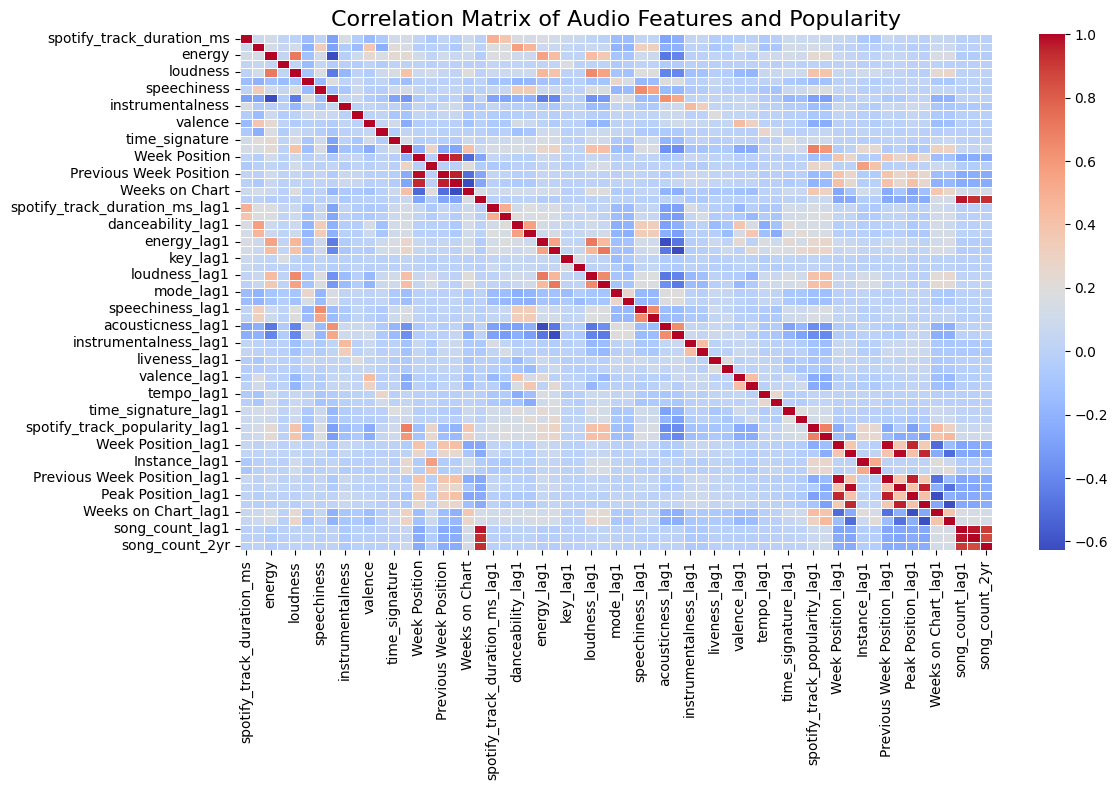

In [210]:
# plot correlation matrix heatmap
corr = genre_df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix of Audio Features and Popularity", fontsize=16)
plt.tight_layout()
plt.show()

<Axes: >

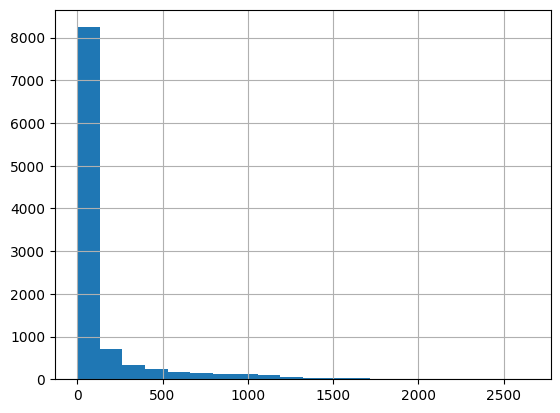

In [211]:
# explore target variable distribution
genre_df['song_count_2yr'].hist(bins=20)

After looking at the distribution of my target variable, it's clearly very skewed. Most models trained with this raw target variable will simply learn to predict a lower song count. To try and fix this, I'll perform a log transformation which will make the distribution more normal. The model will learn with the log-transformed values instead and when I get the prediction I can inverse the transformation to get raw song counts again.

<Axes: >

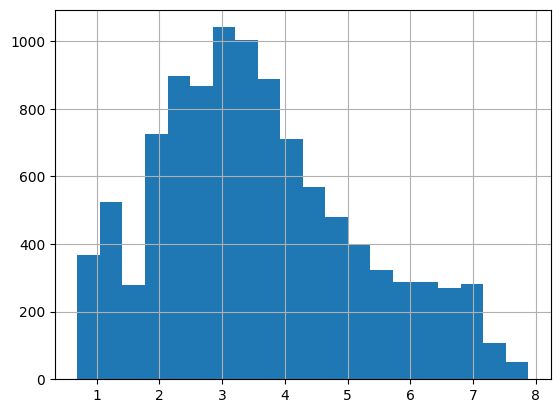

In [212]:
# log transform the target variable to make distribution more normal
genre_df['song_count_2yr'] = np.log1p(genre_df['song_count_2yr'])
genre_df['song_count_2yr'].hist(bins=20)

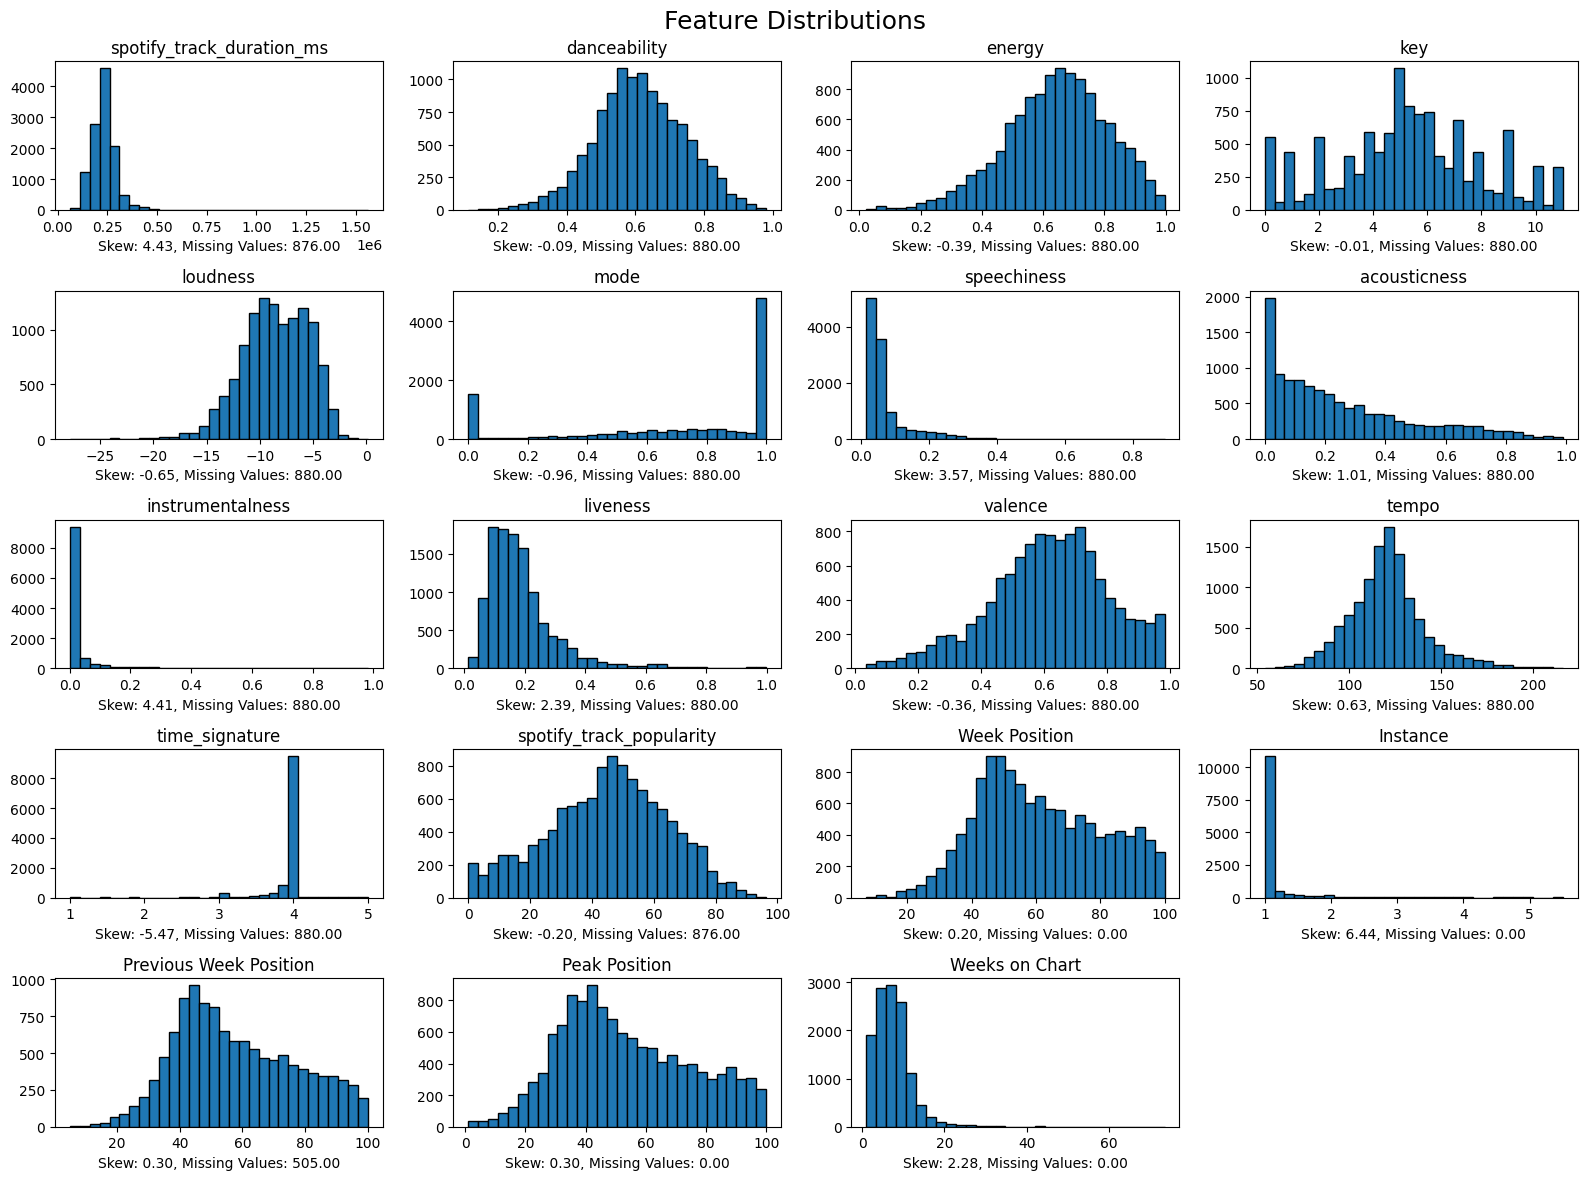

In [213]:
# let's look at numerical feature distributions (exclude lag features since the same)
ax = genre_df[num_cols].hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    grid=False
)

# add skewness to each plot
axes = ax.flatten()
for ax, col in zip(axes, num_cols):
    skew_val = genre_df[col].skew()
    total_nas = genre_df[col].isna().sum()
    ax.set_xlabel(f'Skew: {skew_val:.2f}, Missing Values: {total_nas:.2f}', fontsize=10)

plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

We can use the knowledge of the distributions (and level of skewness) to handle missing data now. If data is skewed, we can impute with median value since this will better reflect the typical distribution of that feature. This is becuase median is robust to outliers while mean can be greatly affected by just a few very different data points. If the distribution is already relatively normal, using mean should be fine.

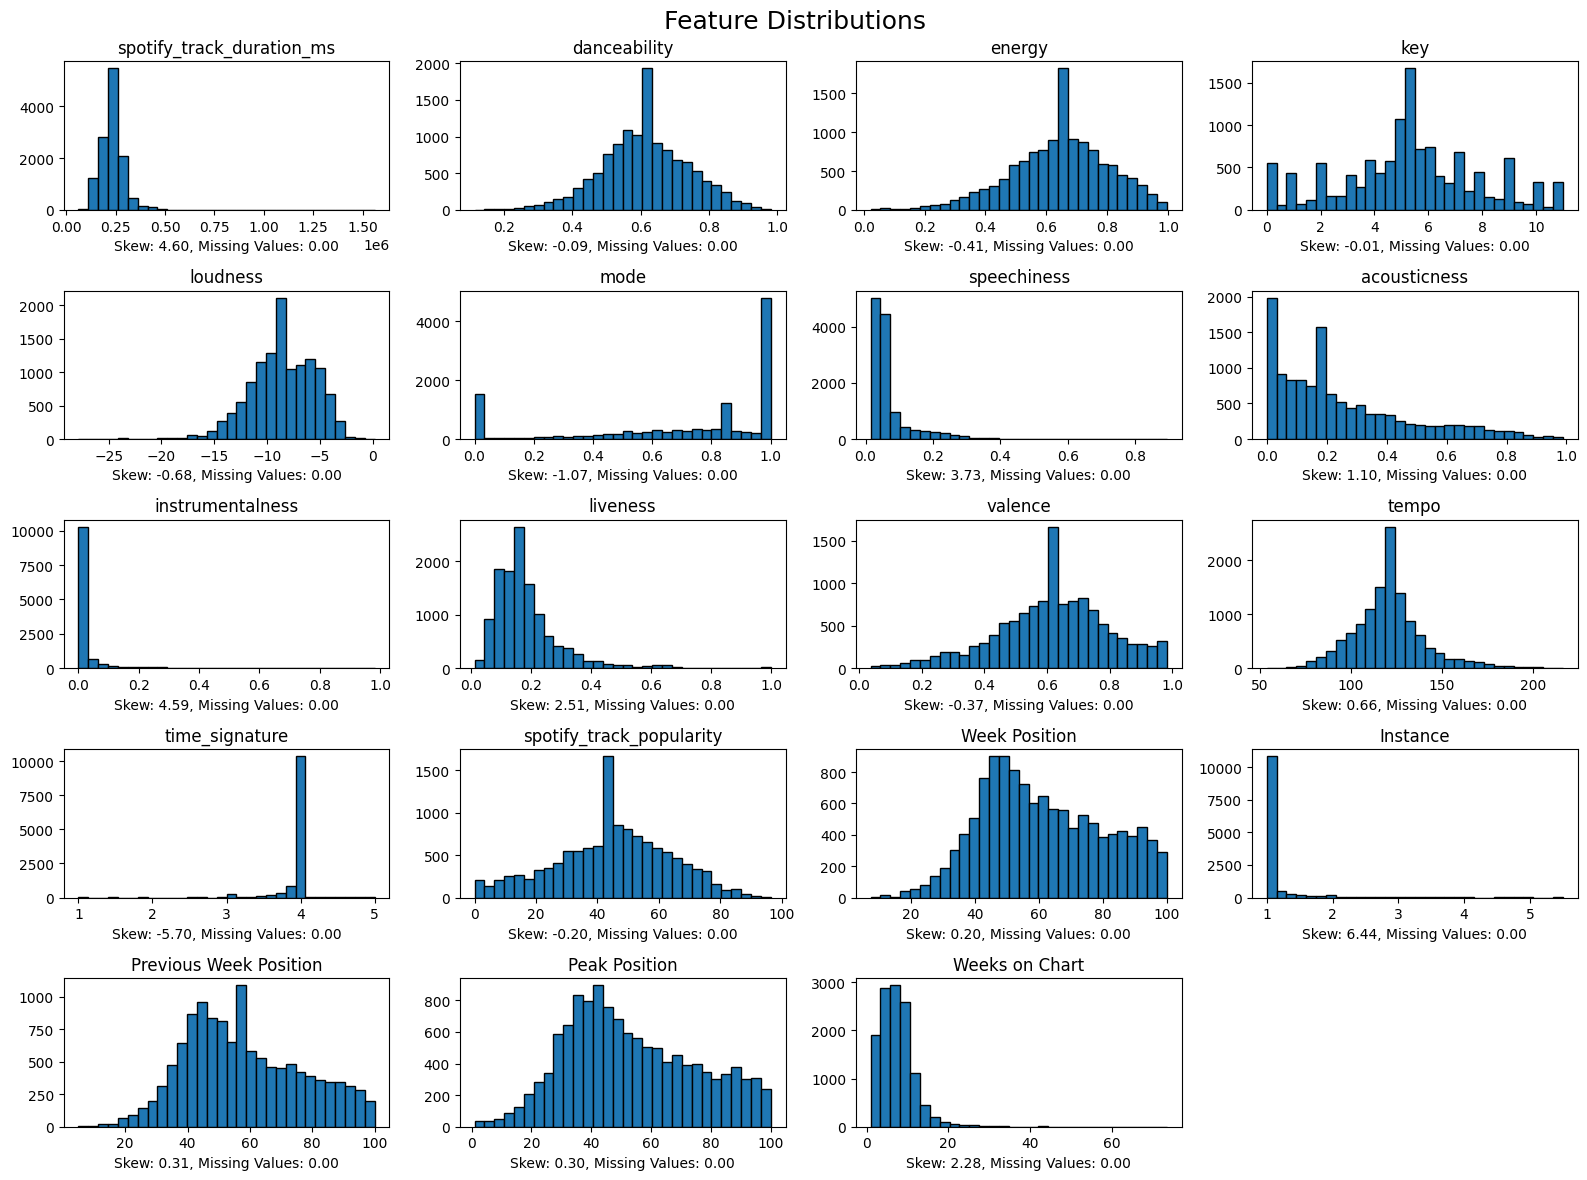

In [214]:
# handle missing values
# lag features with na will be dropped before training
for col in num_cols:
    # if abs(skew) is > 0.5, then I'll impute with median, else mean is fine (normal distribution)
    skew = genre_df[col].skew()
    if abs(skew) > 0.5:
        genre_df[col] = genre_df[col].fillna(genre_df[col].median())
    else:
        genre_df[col] = genre_df[col].fillna(genre_df[col].mean())
        
# plot distributions again to see changes
ax = genre_df[num_cols].hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    grid=False
)

# add skewness to each plot
axes = ax.flatten()
for ax, col in zip(axes, num_cols):
    skew_val = genre_df[col].skew()
    total_nas = genre_df[col].isna().sum()
    ax.set_xlabel(f'Skew: {skew_val:.2f}, Missing Values: {total_nas:.2f}', fontsize=10)

plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

Now, before PCA and model training, I'll do final data preparation. First, I'll split off the records with missing target variable and save it for out of sample forecasting (for future years). Next, I'll remove all the samples with missing lag features as they will not be used for training. Finally, I'll be left with no missing data and will then create a separate normalized dataframe that will be used for PCA, linear regression, and neural network. I'll keep the raw data for my tree based model.

In [215]:
# save data with missing target variable
oos_df = genre_df[genre_df['song_count_2yr'].isna()]

# remove all samples with missing lag features (only columns with remainning missing data)
print(genre_df.info())
genre_df = genre_df.dropna()
print(genre_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12383 entries, 0 to 12382
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   spotify_genre                   12383 non-null  object 
 1   Year                            12383 non-null  object 
 2   spotify_track_duration_ms       12383 non-null  float64
 3   danceability                    12383 non-null  float64
 4   energy                          12383 non-null  float64
 5   key                             12383 non-null  float64
 6   loudness                        12383 non-null  float64
 7   mode                            12383 non-null  float64
 8   speechiness                     12383 non-null  float64
 9   acousticness                    12383 non-null  float64
 10  instrumentalness                12383 non-null  float64
 11  liveness                        12383 non-null  float64
 12  valence                         

['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'spotify_track_popularity', 'Week Position', 'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'song_count', 'spotify_track_duration_ms_lag1', 'spotify_track_duration_ms_lag2', 'danceability_lag1', 'danceability_lag2', 'energy_lag1', 'energy_lag2', 'key_lag1', 'key_lag2', 'loudness_lag1', 'loudness_lag2', 'mode_lag1', 'mode_lag2', 'speechiness_lag1', 'speechiness_lag2', 'acousticness_lag1', 'acousticness_lag2', 'instrumentalness_lag1', 'instrumentalness_lag2', 'liveness_lag1', 'liveness_lag2', 'valence_lag1', 'valence_lag2', 'tempo_lag1', 'tempo_lag2', 'time_signature_lag1', 'time_signature_lag2', 'spotify_track_popularity_lag1', 'spotify_track_popularity_lag2', 'Week Position_lag1', 'Week Position_lag2', 'Instance_lag1', 'Instance_lag2', 'Previous Week Position_lag1', 'Previous Wee

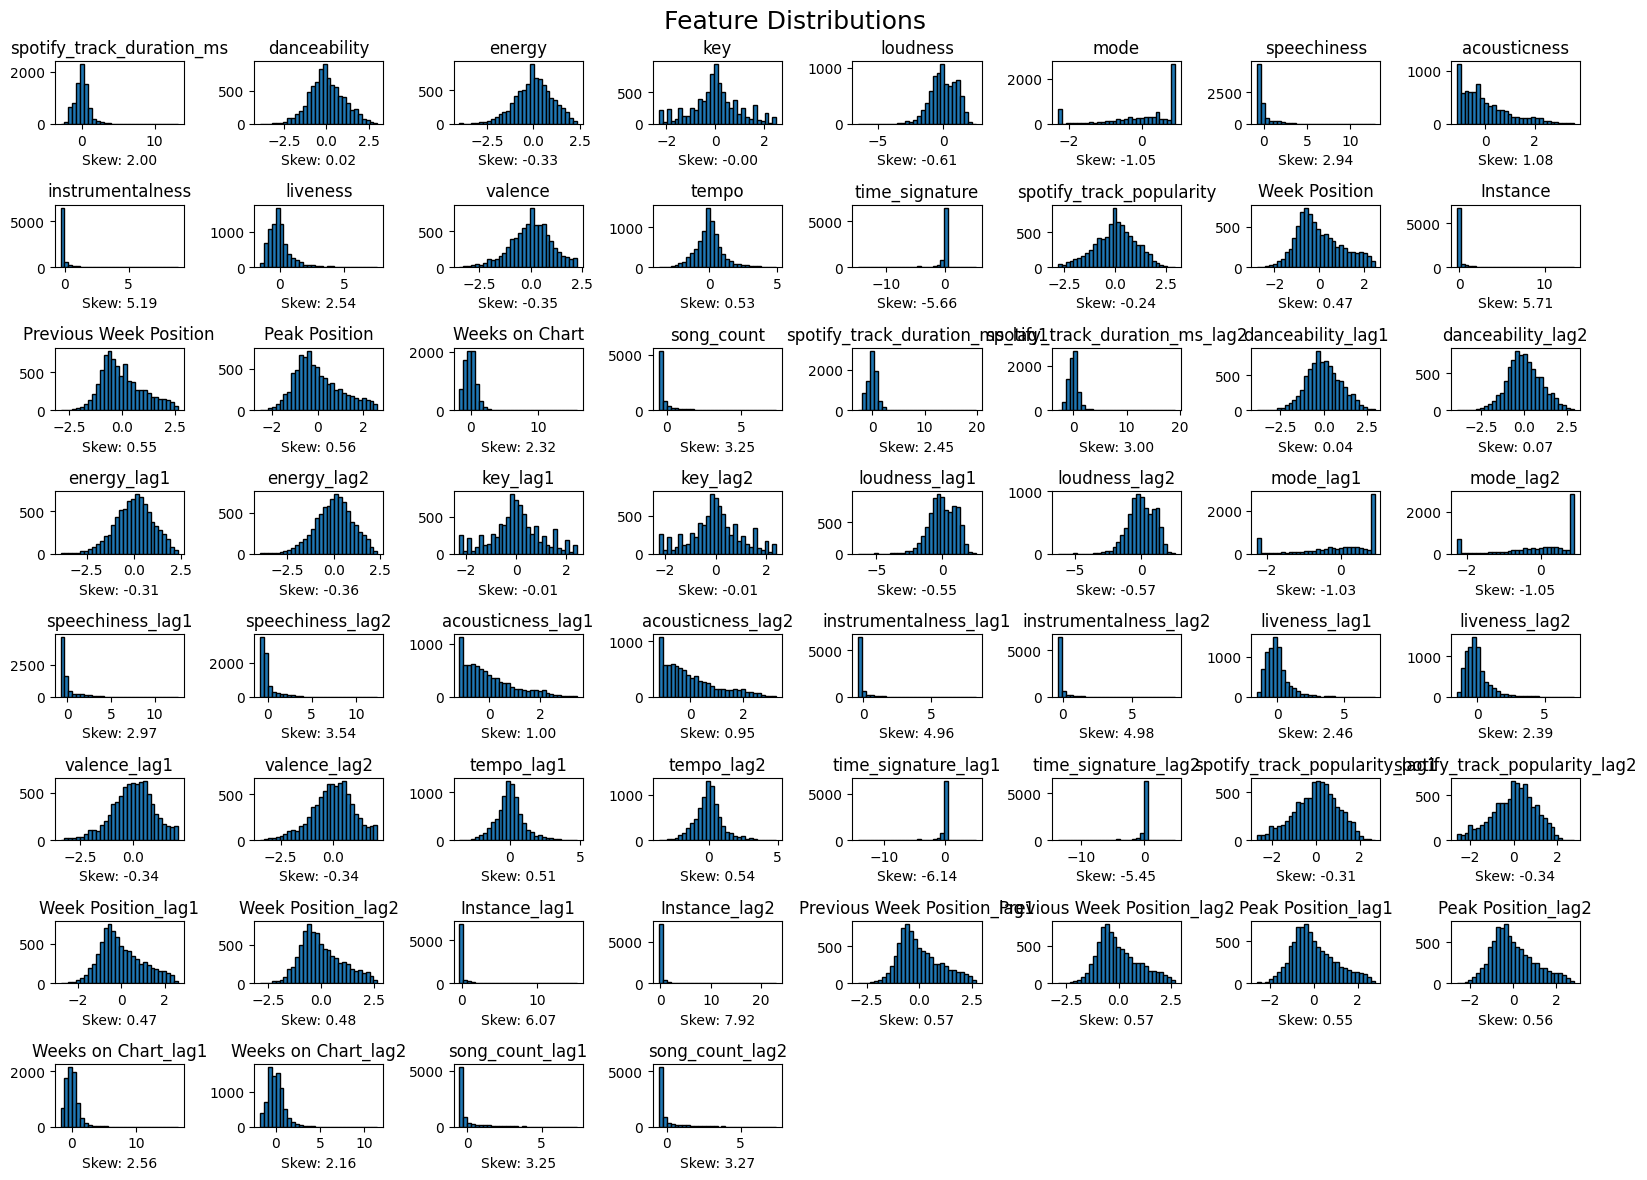

In [216]:
# normalize the data
scaler = StandardScaler()
genre_df_normalized = genre_df.copy(deep=True)
num_cols = [col for col in genre_df.select_dtypes(include='number').columns
            if col not in ['song_count_2yr']] # exclude target variable from normalization
print(num_cols)
genre_df_normalized[num_cols] = scaler.fit_transform(genre_df_normalized[num_cols])

# plot distributions again to see changes
ax = genre_df_normalized[num_cols].hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    grid=False
)

# add skewness to each plot
axes = ax.flatten()
for ax, col in zip(axes, num_cols):
    skew_val = genre_df_normalized[col].skew()
    ax.set_xlabel(f'Skew: {skew_val:.2f}', fontsize=10)

plt.suptitle('Feature Distributions', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [217]:
# differences between normalized and non-normalized data
print(genre_df_normalized.head(5))
print(genre_df.head(5))

  spotify_genre  Year  spotify_track_duration_ms  danceability    energy  \
4    a cappella  1964                  -1.031384     -0.052835 -2.623271   
5    a cappella  1965                  -1.349666     -0.331727 -1.939548   
6    a cappella  1966                  -0.977282      0.223734 -1.431629   
7    a cappella  1967                  -1.595956      0.139281 -0.933760   
8    a cappella  1968                  -1.624499     -0.965606 -1.011442   

        key  loudness      mode  speechiness  acousticness  ...  \
4 -0.850510 -1.079112  0.920685    -0.587843      2.606572  ...   
5  0.313808 -1.209127  0.920685    -0.595739      2.294773  ...   
6 -1.432668 -2.654077  0.920685    -0.684778      2.624407  ...   
7 -0.662164 -0.561407  0.920685    -0.412883      0.001248  ...   
8  0.750427 -1.214797  0.920685    -0.317120      0.756608  ...   

   Instance_lag2  Previous Week Position_lag1  Previous Week Position_lag2  \
4      -0.296134                    -1.154315                 

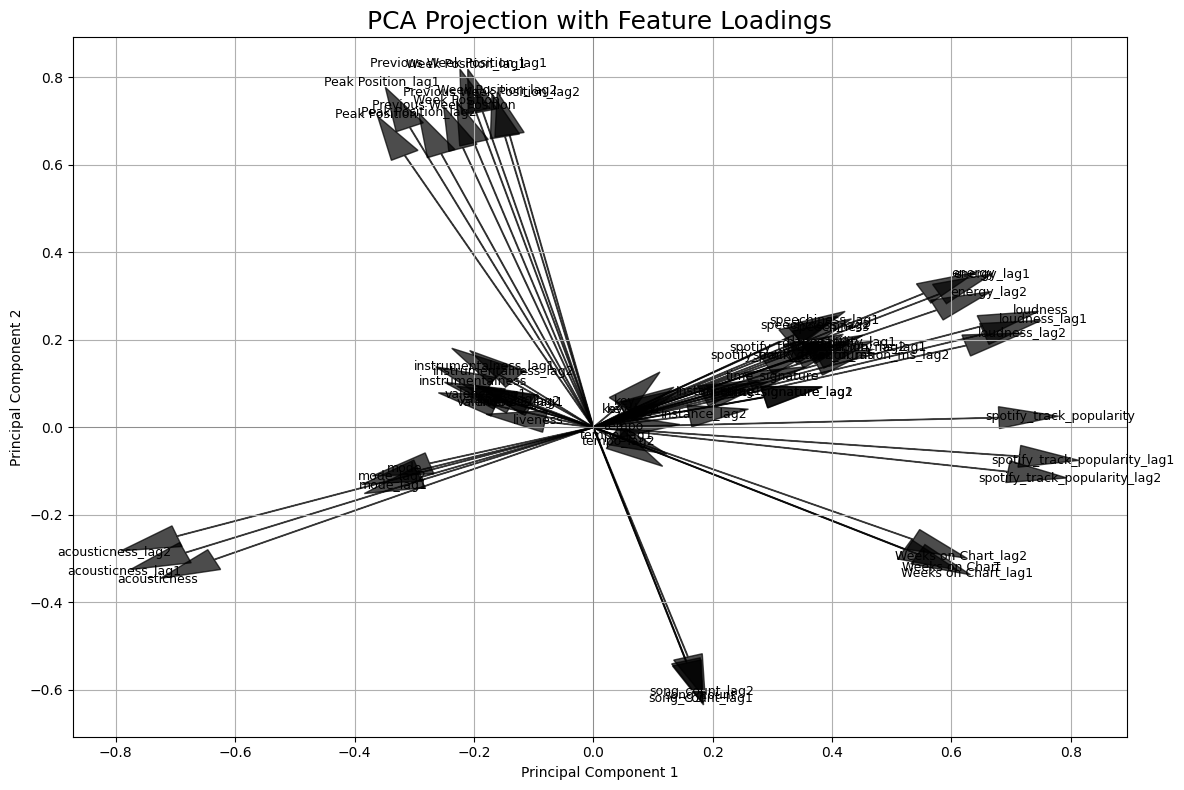

In [218]:
# PCA to visualize data separation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(genre_df_normalized[num_cols])

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot the PCA loadings (arrows)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

for i, feature in enumerate(num_cols):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              color='black', alpha=0.7, head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, 
             color='black', ha='center', va='center', fontsize=9)

# Titles and labels
plt.title('PCA Projection with Feature Loadings', fontsize=18)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

Here we can see that lag features obvious add a good amount of multicollinearity which is important to remove for linear models. So, I'll be using Lasso Regression (learned about it in my Intro to Statistical Learning class) to regularize and perform feature selection for me.

In [221]:
# Define features to use
feature_cols = [col for col in genre_df_normalized.columns if col not in ['spotify_genre', 'Year', 'song_count_2yr']]

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    genre_df_normalized[feature_cols],
    genre_df_normalized['song_count_2yr'],
    test_size=0.15,
    random_state=1
)

In [224]:
# train Lasso model
lasso = LassoCV(cv=5, random_state=1)
lasso.fit(X_train, y_train)

# view coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})

print(coef_df.sort_values(by='Coefficient', ascending=False))

                           Feature  Coefficient
19                      song_count     1.060621
54              Peak Position_lag1     0.221883
49              Week Position_lag2     0.149232
17                   Peak Position     0.113047
16          Previous Week Position     0.081310
46   spotify_track_popularity_lag1     0.074301
21  spotify_track_duration_ms_lag2     0.040530
6                      speechiness     0.031049
13        spotify_track_popularity     0.029961
1                     danceability     0.027497
47   spotify_track_popularity_lag2     0.023482
11                           tempo     0.022584
23               danceability_lag2     0.022111
40                    valence_lag1     0.014810
30                       mode_lag1     0.012549
0        spotify_track_duration_ms     0.010581
22               danceability_lag1     0.010026
18                  Weeks on Chart     0.008693
10                         valence     0.007538
20  spotify_track_duration_ms_lag1     0

In [226]:
# Predict on validation set
y_val_pred = lasso.predict(X_test)

# Evaluate
rmse_log_train = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
rmse_train = np.expm1(rmse_log_train) # convert back to original scale for true rmse
r2_train = r2_score(y_train, lasso.predict(X_train))

rmse_log_test = np.sqrt(mean_squared_error(y_test, y_val_pred))
rmse_test = np.expm1(rmse_log_test) # convert back to original scale for true rmse
r2_test = r2_score(y_test, y_val_pred)

print(f"Best alpha: {lasso.alpha_:.5f}")
print(f"Train RMSE: {rmse_train:.3f}")
print(f"Train R²: {r2_train:.3f}")
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

Best alpha: 0.00178
Train RMSE: 2.022
Train R²: 0.546
Test RMSE: 2.144
Test R²: 0.519


The Lasso model performed pretty well. 5 folds were chosen for CV (to tune for alpha), but more experimentation will be done if Lasso proves to do better off initial training than the proceeding models. Viewing the coefficients helped to see which features got selected and/or were emphasized more. There doesn't appear to be any overfitting occuring which is good, but there is some underfit and we could probably get some better results with a more complex (maybe non-linear) model. So, next I am going to try XGBoost.